<a href="https://colab.research.google.com/github/burroughs121/es2245good/blob/main/ES2245_lab2%2C_Liz_Burroughs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Experimental Design & The "Geospatial Trap"
**Course:** ES2245, The Ohio State University

**Duration:** ~60 Minutes

**Textbook Reference:** *Geostatistics Explained*, Chapter 4

## Objective
In this lab, you will use Python to simulate experimental errors.

**Key Concepts:**
1.  **Pseudoreplication:** The danger of spatial autocorrelation (The "Plowed Field" problem).
2.  **Randomization:** How to fix confounding variables in the lab.
3.  **BACI Design:** Handling unreplicated "Impact" events (Before-After-Control-Impact).
4.  **Data Integrity:** Writing code to filter bad data (Section 4.6).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set visual styles
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]
np.random.seed(42)

print("Libraries Loaded.")

Libraries Loaded.


## Part 1: The Geospatial Trap (Pseudoreplication)

### The Scenario
You are testing a hypothesis: **"Does proximity to a road increase lead (Pb) concentrations in soil?"**
* **Reality:** The road has **zero** effect.
* **Confounding Variable:** There is a natural geological gradient where Lead increases from West to East.
* **Your Task:** Prove that sampling only one location leads to a "False Positive."

### Exercise 1.1: Generate the Landscape
I have provided the code to generate the grid `true_Pb` (the ground truth). Run this cell to visualize the map.

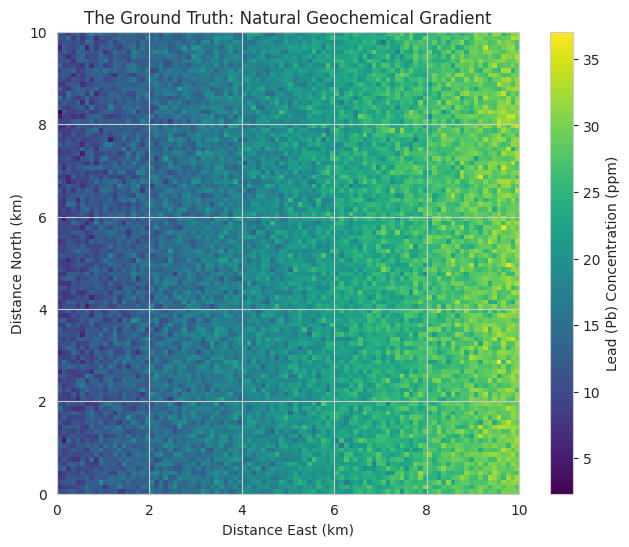

In [2]:
# 1. Create a spatial grid (10km x 10km)
x = np.linspace(0, 10, 100)
y = np.linspace(0, 10, 100)
X, Y = np.meshgrid(x, y)

# 2. Define the "Truth" (Geological Gradient: Low in West, High in East)
true_Pb = 10 + (2.0 * X) + np.random.normal(0, 2, (100,100))

# Visualize
plt.figure(figsize=(8,6))
plt.imshow(true_Pb, origin='lower', extent=[0,10,0,10], cmap='viridis')
plt.colorbar(label='Lead (Pb) Concentration (ppm)')
plt.title("The Ground Truth: Natural Geochemical Gradient")
plt.xlabel("Distance East (km)")
plt.ylabel("Distance North (km)")
plt.show()

### Exercise 1.2: Implement the "Bad" Sampling Design
You need to extract samples from specific areas to simulate the "Plowed Field" error.

1.  Create a boolean mask `mask_A` where **X > 8** (The "Road" site).
2.  Create a boolean mask `mask_B` where **X < 2** (The "Nature Reserve").
3.  Apply these masks to `true_Pb` to get your populations.
4.  Randomly select 50 points from each using `np.random.choice`.
5.  Run a T-test. (An example in the lecture 3 jupyter notebook does this with the scipy package - Also, at the bottom, is an appendix with a description of a t-test and p-values)

In [8]:
# --- STEP 1: Create Boolean Masks ---
# Hint: Use the X grid created above.
# mask_A should be True where X > 8.
# mask_B should be True where X < 2.

# YOUR CODE HERE
mask_A = X > 8
mask_B = X < 2
# --- STEP 2: Apply masks to true_Pb to get the populations ---
# Hint: population = data[mask]


# YOUR CODE HERE
pop_A = true_Pb[mask_A]
pop_B = true_Pb[mask_B]

# --- STEP 3: Downsample ---
# Use np.random.choice(population, size=50) to create sample_A and sample_B

# YOUR CODE HERE
sample_A = np.random.choice(pop_A, size=50)
sample_B = np.random.choice(pop_B, size=50)

# --- STEP 4: Statistics ---
# Use stats.ttest_ind(group1, group2) to get the t-statistic and p-value

# YOUR CODE HERE
t_stat, p_val = stats.ttest_ind(sample_A, sample_B)

# --- Output Results ---
print(f"Mean Pb (Near Road): {sample_A.mean():.2f}")
print(f"Mean Pb (Nature Reserve): {sample_B.mean():.2f}")
print(f"P-value: {p_val:.10f}")

Mean Pb (Near Road): 28.90
Mean Pb (Nature Reserve): 11.56
P-value: 0.0000000000


### Discussion Question 1
**The p-value is likely extremely small (significant). Explain precisely why this result is scientifically invalid, even though the math is correct.**

> The result is invalid because there is a natural gradient of led distribution from West to East, so the road actually has no effect on the lead content dispite the math being correct.

## Part 2: Fixing it with Randomization

To fix the problem above, we need to break the correlation between **Location** and **Treatment**.

### Exercise 2.1: Random Sampling Loop
Instead of sampling the East vs. West, you must sample randomly from the **entire** map. To prove this works, write a `for` loop that runs the experiment **100 times**.

**Requirements:**
1.  Flatten `true_Pb` into a 1D array.
2.  Write a loop that runs 100 times.
3.  Inside the loop, pick 50 random samples for Group A and 50 for Group B (from the *same* whole population).
4.  Run a t-test and store the p-value in a list called `p_values`.
5.  Calculate how many times the p-value was < 0.05 (False Positives).

Total Experiments: 100
Number of False Positives (p < 0.05): 0
Expected False Positives: ~5


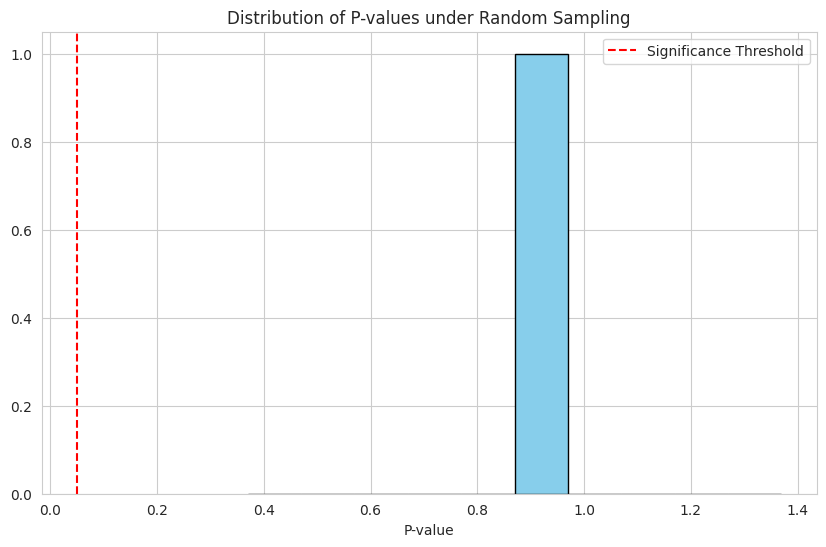

In [9]:
# Flatten the map
all_soil_data = true_Pb.flatten()

# Initialize an empty list to store p-values
p_values = []

# --- Write your Loop below ---
# range(100)
    # 1. Select 50 random samples for group_a
    # 2. Select 50 random samples for group_b
    # 3. Run t-test
    # 4. Append p-value to the list 'p_values'

# YOUR CODE HERE
for i in range(100):
  group_a = np.random.choice(all_soil_data, size=50)
  group_b = np.random.choice(all_soil_data, size=50)
  t_stat,p_val = stats.ttest_ind(group_a, group_b)

p_values.append(p_val)
# --- Analysis ---
# Convert list to numpy array for easy math
p_arr = np.array(p_values)

# Calculate percentage of False Positives (where p < 0.05)
false_positives = np.sum(p_arr < 0.05)

print(f"Total Experiments: 100")
print(f"Number of False Positives (p < 0.05): {false_positives}")
print("Expected False Positives: ~5")

# Visualization
plt.hist(p_arr, bins=10, color='skyblue', edgecolor='black')
plt.title("Distribution of P-values under Random Sampling")
plt.xlabel("P-value")
plt.axvline(0.05, color='red', linestyle='--', label='Significance Threshold')
plt.legend()
plt.show()

## Part 3: The "Unreplicated" Experiment (BACI)

You are analyzing a river where a dam was built at **Time = 30**. You need to generate the synthetic data to model this.

### Exercise 3.1: Generate Time-Series Data
Construct the arrays `control_river` and `impact_river` using NumPy math functions.

**Requirements:**
1.  `time`: an array of integers from 0 to 60.
2.  `seasonality`: Calculate `np.sin(time / 3) * 5`.
3.  `dam_effect`: An array of zeros, but change indices 30 through 60 to equal **-15** (a drop in fish count).
4.  Add these components together (plus random noise) to create the river data.

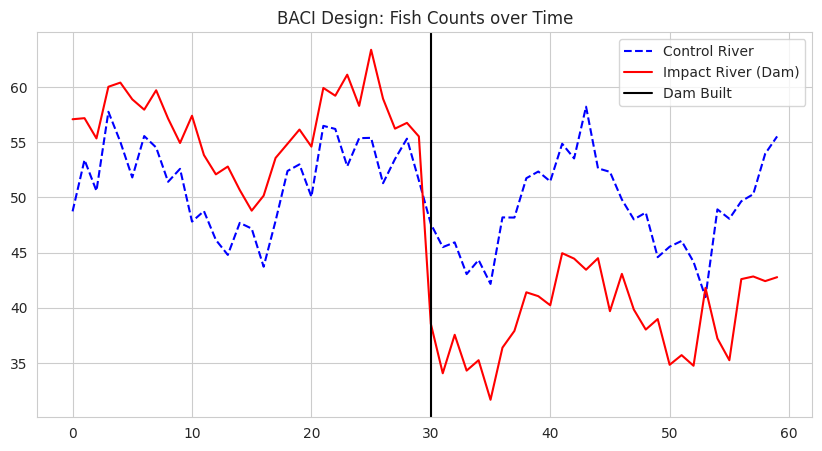

In [15]:
# 1. Create Time Array (0 to 60)
# YOUR CODE HERE
time = np.arange(0, 60)

# 2. Create Seasonality (Sin wave)
# YOUR CODE HERE
seasonality = np.sin(time / 3) *5

# 3. Create the Control River
# Base level of 50 + seasonality + random noise (use np.random.normal(0, 2, 60))
# YOUR CODE HERE
control_river = 50 + seasonality + np.random.normal(0, 2, 60)

# 4. Create the Dam Effect
# Create an array of zeros matching the length of 'time'
# Set the values from index 30 to the end to be -15
# YOUR CODE HERE
dam_effect = np.zeros(60)
dam_effect[30:]= -15


# 5. Create Impact River
# Base level of 55 + seasonality + dam_effect + random noise
# YOUR CODE HERE
impact_river = 55 + seasonality + dam_effect + np.random.normal(0, 2, 60)


# --- Plotting (Do not change) ---
plt.figure(figsize=(10,5))
plt.plot(time, control_river, label='Control River', color='blue', linestyle='--')
plt.plot(time, impact_river, label='Impact River (Dam)', color='red')
plt.axvline(30, color='black', label='Dam Built')
plt.title("BACI Design: Fish Counts over Time")
plt.legend()
plt.show()

### Exercise 3.2: The Delta Calculation
Calculate and plot the difference between the two rivers.

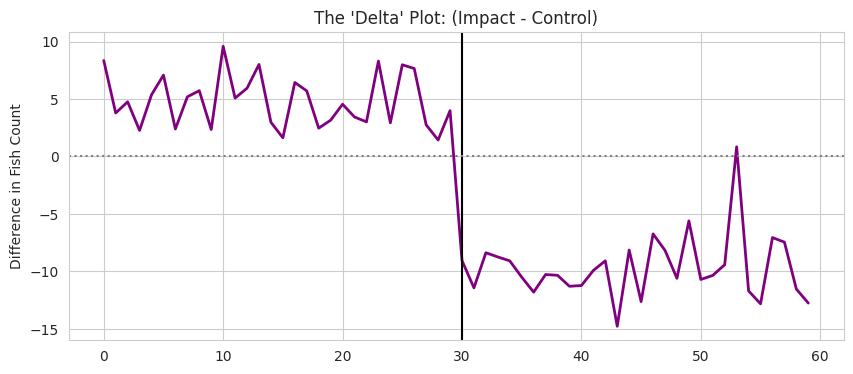

In [16]:
# Calculate difference (Impact - Control)
# YOUR CODE HERE
difference = impact_river - control_river

# Plot
plt.figure(figsize=(10,4))
plt.plot(time, difference, color='purple', linewidth=2)
plt.axvline(30, color='black', label='Dam Built')
plt.axhline(0, color='gray', linestyle=':')
plt.title("The 'Delta' Plot: (Impact - Control)")
plt.ylabel("Difference in Fish Count")
plt.show()

## Part 4: Data Integrity (Writing a Filter)

Section 4.6 of the text warns about outliers. You have a dataset that contains a data entry error (a value that is physically impossible or statistically improbable).

### Exercise 4.1: Write a Cleaning Function
Write a function `clean_data(arr)` that:
1.  Calculates the **Median** of the array.
2.  Calculates the **Standard Deviation** of the array.
3.  Returns a new array containing only values that are within **2 standard deviations** of the median.

In [29]:
# The Dirty Data
data_raw = np.array([2.9, 3.1, 3.0, 2.8, 3.2, 3.0, 3.1, 30.0, 2.9, 3.0])

def clean_data(arr):
    # 1. Calculate Median
    # YOUR CODE HERE
    med = np.median(arr)

    # 2. Calculate Std Dev
    # YOUR CODE HERE
    std = np.std(arr)

    # 3. Define the cutoff (Median +/- 2*Std)
    lower_limit = med - (2 * std)
    upper_limit = med + (2 * std)

    # 4. Filter the array using boolean indexing
    # Return only the values inside the limits
    # YOUR CODE HERE
    clean_ind = np.where((arr <= upper_limit)&(arr >= lower_limit))[0]
    clean_arr = arr[clean_ind]

    return clean_arr

# --- Test your function ---
data_clean = clean_data(data_raw)

print(f"Original Mean: {data_raw.mean():.2f}")
print(f"Cleaned Mean:  {data_clean.mean():.2f}")

if data_clean.max() < 4.0:
    print("SUCCESS: Outlier removed.")
else:
    print("FAIL: Outlier still present.")

Original Mean: 5.70
Cleaned Mean:  3.00
SUCCESS: Outlier removed.


### Discussion Question 2
**Why did we use the Median to set the center of our filter, rather than the Mean?**

> The median is not effected by a single outlier, so it wouldn't be skewed like the mean would, because the mean takes all the data points into consideration.

#Appendix

# The Student's T-Test: Signal vs. Noise

## 1. Concept
The **t-test** is an inferential statistic used to determine if there is a significant difference between the means of two groups.

In the context of **Chapter 4**, think of the t-test as a ratio of **Signal** to **Noise**:

* **Signal (Numerator):** The difference between the two group means ($\bar{x}_1 - \bar{x}_2$).
* **Noise (Denominator):** The variability (standard error) within the groups.

$$t = \frac{\text{Signal}}{\text{Noise}} = \frac{\text{Difference between Means}}{\text{Variability of Data}}$$

If the **Signal** is large relative to the **Noise**, the t-value will be large, suggesting the difference is real (not just luck).

## 2. Types of T-Tests
1.  **Independent Samples T-Test:** Compares two entirely separate groups (e.g., *Site A vs. Site B*). This assumes the samples are independent.
2.  **Paired Samples T-Test:** Compares the same group at two different times (e.g., *Before Impact vs. After Impact*).
3.  **One-Sample T-Test:** Compares one group against a known standard (e.g., *Is this rock's density significantly different from 3.0?*).

## 3. The Math (Independent Samples)
The formula for the t-statistic is:

$$t = \frac{\bar{X}_1 - \bar{X}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$$

Where:
* $\bar{X}$: Mean of the group
* $s$: Standard deviation
* $n$: Sample size (Number of replicates)

## 4. Understanding the P-value
The **P-value** (Probability value) is the final output of the test, but it is often misunderstood.

* **Definition:** The probability of seeing a difference *at least this large* if the Null Hypothesis were actually true (i.e., if there were truly no effect).
* **It is NOT:** The probability that your hypothesis is correct.
* **It IS:** A measure of "surprise." A low p-value means "It would be very surprising to see this difference just by random luck."

### Interpreting the Threshold ($\alpha = 0.05$):
* **$P < 0.05$ (Significant):** The chance that this result is a "fluke" is less than 5%. We reject the Null Hypothesis.
* **$P > 0.05$ (Not Significant):** The difference could easily happen by random chance (noise). We cannot claim a real effect.

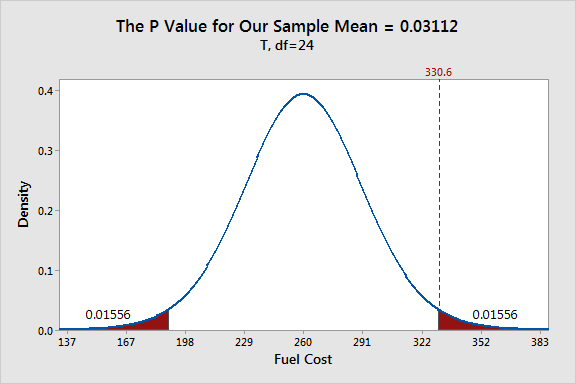


*Think of the p-value as a "Fluke Detector." If the p-value is 0.03, there is only a 3% chance that random noise created this pattern.*

## 5. Assumptions (Crucial!)
For a t-test to be valid, your data must meet these criteria. **Violating these leads to the errors discussed in Chapter 4.**
* **Independence:** Samples must not be autocorrelated (No pseudoreplication!).
* **Normality:** Data should follow a roughly Normal (Bell curve) distribution.
* **Homogeneity of Variance:** Both groups should have roughly the same amount of scatter (standard deviation).

## 6. Implementation in Python
We use `scipy.stats` to perform the calculation.

```python
from scipy import stats

# Example: Testing if Group A differs from Group B
t_stat, p_val = stats.ttest_ind(group_a_data, group_b_data)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")